In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter

Using TensorFlow backend.


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [10]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_category)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize=1024, overlap=512, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return items

Overwriting load_blockwise.py


In [11]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2484.37 MiB, increment: 2179.17 MiB
CPU times: user 4min 8s, sys: 1.57 s, total: 4min 10s
Wall time: 4min 10s


In [12]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1789.69 MiB, increment: 490.75 MiB
CPU times: user 1min 3s, sys: 552 ms, total: 1min 4s
Wall time: 1min 4s


## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 50
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=SR,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [14]:
%%time

clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net,
                       epochs=epochs, 
                       batch_size=batch, 
                       validation_split=0.15)

%memit history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

Epoch 35/50
1360/1360 [==============================] - 39s 28ms/step - loss: 0.1437 - acc: 0.9485 - mean_absolute_error: 0.0970 - val_loss: 0.6928 - val_acc: 0.8208 - val_mean_absolute_error: 0.1816
Epoch 36/50
1360/1360 [==============================] - 39s 29ms/step - loss: 0.1329 - acc: 0.9441 - mean_absolute_error: 0.0875 - val_loss: 0.6062 - val_acc: 0.8333 - val_mean_absolute_error: 0.1821
Epoch 37/50
1360/1360 [==============================] - 39s 29ms/step - loss: 0.1256 - acc: 0.9551 - mean_absolute_error: 0.0848 - val_loss: 0.5979 - val_acc: 0.8500 - val_mean_absolute_error: 0.1789
Epoch 38/50
1360/1360 [==============================] - 38s 28ms/step - loss: 0.1236 - acc: 0.9522 - mean_absolute_error: 0.0798 - val_loss: 0.7842 - val_acc: 0.8125 - val_mean_absolute_error: 0.1888
Epoch 39/50
1360/1360 [==============================] - 38s 28ms/step - loss: 0.1064 - acc: 0.9588 - mean_absolute_error: 0.0741 - val_loss: 0.6076 - val_acc: 0.8500 - val_mean_absolute_error: 0.

# Low-Level Deep Net

### Animal

In [15]:
def deep_net_a():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=SR,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(18, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [16]:
%%time
clf_a = KerasClassifier(build_fn=deep_net_a, 
                          epochs=50, 
                          batch_size=35,
                          validation_split=0.15)

%memit history_a = clf_a.fit(train_X[train_y == 0], train_yy[train_y == 0])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

Epoch 33/50
489/489 [==============================] - 16s 33ms/step - loss: 1.3685 - acc: 0.5215 - mean_absolute_error: 0.0931 - val_loss: 2.7223 - val_acc: 0.3103 - val_mean_absolute_error: 0.0957
Epoch 34/50
489/489 [==============================] - 16s 33ms/step - loss: 1.3975 - acc: 0.5133 - mean_absolute_error: 0.0909 - val_loss: 2.6671 - val_acc: 0.3448 - val_mean_absolute_error: 0.0980
Epoch 35/50
489/489 [==============================] - 16s 33ms/step - loss: 1.2886 - acc: 0.5399 - mean_absolute_error: 0.0911 - val_loss: 3.0273 - val_acc: 0.2989 - val_mean_absolute_error: 0.0975
Epoch 36/50
489/489 [==============================] - 16s 33ms/step - loss: 1.3586 - acc: 0.5133 - mean_absolute_error: 0.0849 - val_loss: 2.6717 - val_acc: 0.3448 - val_mean_absolute_error: 0.0959
Epoch 37/50
489/489 [==============================] - 16s 33ms/step - loss: 1.2911 - acc: 0.5399 - mean_absolute_error: 0.0856 - val_loss: 2.8338 - val_acc: 0.2759 - val_mean_absolute_error: 0.0972
Epoch

### Interacting Material

In [17]:
def deep_net_i():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=SR,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
%%time
clf_i = KerasClassifier(build_fn=deep_net_i, 
                                              epochs=50, 
                                              batch_size=35,
                                              validation_split=0.15)

%memit history_i = clf_i.fit(train_X[train_y == 1], train_yy[train_y == 1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                69664     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
__________

Epoch 33/50
870/870 [==============================] - 28s 32ms/step - loss: 1.7824 - acc: 0.3770 - mean_absolute_error: 0.0682 - val_loss: 2.4057 - val_acc: 0.2987 - val_mean_absolute_error: 0.0585
Epoch 34/50
870/870 [==============================] - 28s 32ms/step - loss: 1.7874 - acc: 0.4057 - mean_absolute_error: 0.0655 - val_loss: 2.6139 - val_acc: 0.2922 - val_mean_absolute_error: 0.0644
Epoch 35/50
870/870 [==============================] - 28s 32ms/step - loss: 1.7278 - acc: 0.4149 - mean_absolute_error: 0.0658 - val_loss: 2.3653 - val_acc: 0.2987 - val_mean_absolute_error: 0.0621
Epoch 36/50
870/870 [==============================] - 28s 32ms/step - loss: 1.6843 - acc: 0.4529 - mean_absolute_error: 0.0586 - val_loss: 2.5256 - val_acc: 0.3052 - val_mean_absolute_error: 0.0593
Epoch 37/50
870/870 [==============================] - 28s 32ms/step - loss: 1.6681 - acc: 0.4069 - mean_absolute_error: 0.0599 - val_loss: 2.5460 - val_acc: 0.3117 - val_mean_absolute_error: 0.0589
Epoch

### Scoring

In [20]:
import numpy as np
names_a = []
for name in np.unique(test_yy[test_y == 0]):
    names_a.append(classes[name])
names_i = []
for name in np.unique(test_yy[test_y == 1]):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'clapping', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


0.815
Confusion matrix, without normalization
[[111  33]
 [ 41 215]]


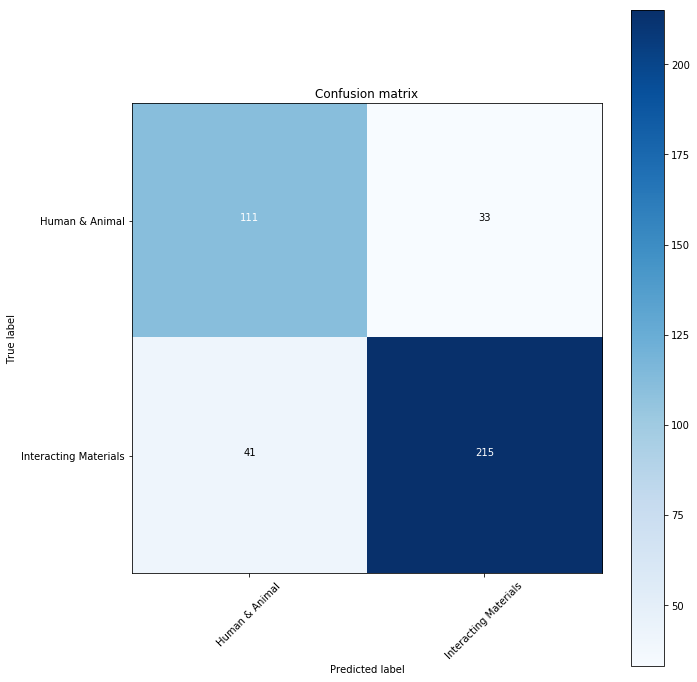

In [21]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

0.3819444444444444
Confusion matrix, without normalization
[[2 0 1 0 0 0 2 0 1 1 0 0 0 0 0 1 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
 [0 2 0 2 0 1 0 1 0 0 0 0 2 0 0 0 0 0]
 [0 0 1 0 4 0 0 0 0 1 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 0 0 0 3 0 0 0 0 2]
 [2 0 0 2 0 0 0 1 0 1 0 0 1 0 0 0 1 0]
 [0 0 1 0 0 0 0 3 2 0 0 0 0 0 1 1 0 0]
 [0 1 0 0 1 0 0 0 3 1 0 0 1 1 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 5 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 3 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 1 1 0 2 3 0 1 0 0 0 0]
 [0 0 0 1 0 3 0 0 2 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 4 0 2 0 1]
 [0 0 2 0 0 0 0 1 0 1 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 2 0 3 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 4 1]
 [0 0 1 0 0 0 0 0 0 0 1 2 0 0 0 0 0 4]]


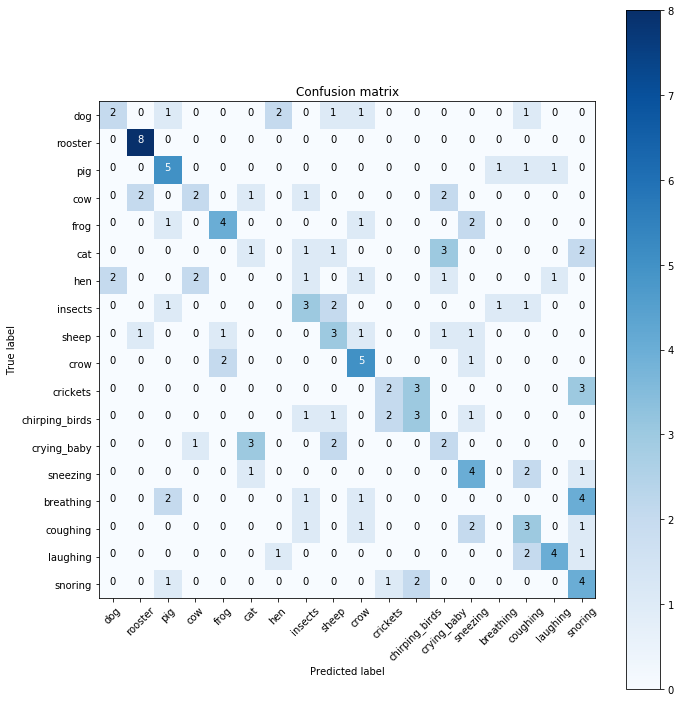

In [22]:
pred = clf_a.predict(test_X[test_y == 0])
print(metrics.accuracy_score(test_yy[test_y == 0], pred))
cm = metrics.confusion_matrix(test_yy[test_y == 0], pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.3828125
Confusion matrix, without normalization
[[6 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [0 0 1 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 2]]


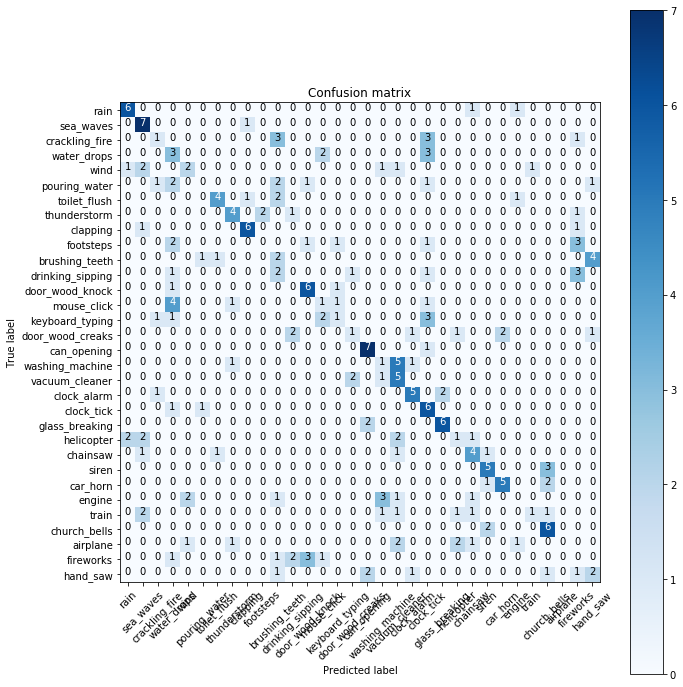

In [23]:
pred = clf_i.predict(test_X[test_y == 1])
print(metrics.accuracy_score(test_yy[test_y == 1], pred))
cm = metrics.confusion_matrix(test_yy[test_y == 1], pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [27]:
%%time
import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = load_file_blockwise(dataset.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = dataset.iloc[data_iloc].h_category
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clas.predict(x_file, verbose=0)[:,0]
    top_pred_probs.append(clas.predict_proba(x_file))
    prob = np.average(top_pred_probs[-1], axis=0)
    if prob[0] > 0.5:
        pred = clf_a.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(clf_a.predict_proba(x_file))
    else:
        pred = clf_i.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(clf_i.predict_proba(x_file))
    
    full_targets.append(yy_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



	File Time: 0.29187941551208496
	File Time: 0.28440189361572266
	File Time: 0.28833746910095215
	File Time: 0.27831363677978516
	File Time: 0.2729611396789551
	File Time: 0.2890176773071289
	File Time: 0.28867602348327637
	File Time: 0.28891420364379883
	File Time: 0.23927903175354004
	File Time: 0.28999805450439453
	File Time: 0.27382946014404297
	File Time: 0.27694153785705566
	File Time: 0.24345135688781738
	File Time: 0.290663480758667
	File Time: 0.28692197799682617
	File Time: 0.2733802795410156
	File Time: 0.2556331157684326
	File Time: 0.24238371849060059
	File Time: 0.2659742832183838
	File Time: 0.31493306159973145
	File Time: 0.2852952480316162
	File Time: 0.2587299346923828
	File Time: 0.23819899559020996
	File Time: 0.22918272018432617
	File Time: 0.2819344997406006
	File Time: 0.25017213821411133
	File Time: 0.2404003143310547
	File Time: 0.2794363498687744
	File Time: 0.2872445583343506
	File Time: 0.2594006061553955
	File Time: 0.2729783058166504
	File Time: 0.275120973

	File Time: 0.23253488540649414
	File Time: 0.2614724636077881
	File Time: 0.2761802673339844
	File Time: 0.21107912063598633
	File Time: 0.25479888916015625
	File Time: 0.25215792655944824
	File Time: 0.24970316886901855
	File Time: 0.23193836212158203
	File Time: 0.1971571445465088
	File Time: 0.1960582733154297
	File Time: 0.230668306350708
	File Time: 0.21669697761535645
	File Time: 0.1845099925994873
	File Time: 0.273773193359375
	File Time: 0.24257540702819824
	File Time: 0.22788357734680176
	File Time: 0.22021913528442383
	File Time: 0.22021484375
	File Time: 0.218796968460083
	File Time: 0.2200160026550293
	File Time: 0.20077276229858398
	File Time: 0.19034767150878906
	File Time: 0.24743366241455078
	File Time: 0.22682976722717285
	File Time: 0.2271864414215088
	File Time: 0.18802475929260254
	File Time: 0.19004154205322266
	File Time: 0.21593809127807617
	File Time: 0.21647167205810547
	File Time: 0.1848621368408203
	File Time: 0.23586130142211914
	File Time: 0.21648836135864

	File Time: 0.2317655086517334
	File Time: 0.25740647315979004
	File Time: 0.24325823783874512
	File Time: 0.2646763324737549
	File Time: 0.2324833869934082
	File Time: 0.2473769187927246
	File Time: 0.2657003402709961
	File Time: 0.25120115280151367
	File Time: 0.271944522857666
	File Time: 0.23107528686523438
	File Time: 0.28148603439331055
	File Time: 0.2691915035247803
	File Time: 0.24477767944335938
	File Time: 0.2898404598236084
	File Time: 0.2651827335357666
	File Time: 0.2767636775970459
	File Time: 0.2851126194000244
	File Time: 0.2607002258300781
	File Time: 0.2534956932067871
	File Time: 0.27810096740722656
	File Time: 0.2543375492095947
	File Time: 0.2818019390106201
	File Time: 0.2622814178466797
	File Time: 0.25675392150878906
	File Time: 0.2406914234161377
	File Time: 0.26004815101623535
	File Time: 0.23595762252807617
	File Time: 0.23428130149841309
	File Time: 0.2263636589050293
	File Time: 0.22939443588256836
	File Time: 0.20132684707641602
	File Time: 0.2672812938690

	File Time: 0.3011629581451416
	File Time: 0.2866678237915039
	File Time: 0.2783198356628418
	File Time: 0.2892115116119385
	File Time: 0.2968778610229492
	File Time: 0.2823357582092285
	File Time: 0.24515032768249512
	File Time: 0.28403329849243164
	File Time: 0.29405641555786133
	File Time: 0.24657511711120605
	File Time: 0.2747626304626465
	File Time: 0.28955817222595215
	File Time: 0.25878000259399414
	File Time: 0.26385045051574707
	File Time: 0.2437458038330078
	File Time: 0.2771291732788086
	File Time: 0.256880521774292
	File Time: 0.23569321632385254
	File Time: 0.28033947944641113
	File Time: 0.28664445877075195
	File Time: 0.2683446407318115
	File Time: 0.23959827423095703
	File Time: 0.29003262519836426
	File Time: 0.28137993812561035
	File Time: 0.2894256114959717
	File Time: 0.24721622467041016
	File Time: 0.2808263301849365
	File Time: 0.23208045959472656
	File Time: 0.24773049354553223
	File Time: 0.276979923248291
	File Time: 0.266481876373291
	File Time: 0.249644517898

	File Time: 0.29463696479797363
	File Time: 0.3127725124359131
	File Time: 0.26677918434143066
	File Time: 0.3039886951446533
	File Time: 0.30449843406677246
	File Time: 0.291363000869751
	File Time: 0.29839301109313965
	File Time: 0.2982211112976074
	File Time: 0.31015801429748535
	File Time: 0.29944753646850586
	File Time: 0.26324033737182617
	File Time: 0.30472493171691895
	File Time: 0.2672455310821533
	File Time: 0.26581883430480957
	File Time: 0.32314276695251465
	File Time: 0.29471826553344727
	File Time: 0.30158090591430664
	File Time: 0.30934810638427734
	File Time: 0.29918432235717773
	File Time: 0.3113062381744385
	File Time: 0.29361772537231445
	File Time: 0.31327080726623535
	File Time: 0.3039994239807129
	File Time: 0.2743375301361084
	File Time: 0.2752406597137451
	File Time: 0.25757527351379395
	File Time: 0.3025553226470947
	File Time: 0.29944825172424316
	File Time: 0.2683436870574951
	File Time: 0.30396246910095215
	File Time: 0.3057725429534912
	File Time: 0.2949764

	File Time: 0.3005836009979248
	File Time: 0.2864389419555664
	File Time: 0.25882816314697266
	File Time: 0.30238914489746094
	File Time: 0.28991031646728516
	File Time: 0.25848984718322754
	File Time: 0.2645418643951416
	File Time: 0.2521955966949463
	File Time: 0.2120521068572998
	File Time: 0.24455022811889648
	File Time: 0.21842074394226074
	File Time: 0.27631115913391113
	File Time: 0.30797648429870605
	File Time: 0.3006258010864258
	File Time: 0.2990107536315918
	File Time: 0.2924923896789551
	File Time: 0.2985494136810303
	File Time: 0.31859803199768066
	File Time: 0.3006415367126465
	File Time: 0.30310773849487305
	File Time: 0.29590463638305664
	File Time: 0.31280064582824707
	File Time: 0.3119931221008301
	File Time: 0.29461050033569336
	File Time: 0.29303598403930664
	File Time: 0.27530407905578613
	File Time: 0.2778775691986084
	File Time: 0.27311134338378906
	File Time: 0.22228121757507324
	File Time: 0.234236478805542
	File Time: 0.2768123149871826
	File Time: 0.243967771

	File Time: 0.3117024898529053
	File Time: 0.29684972763061523
	File Time: 0.31606483459472656
	File Time: 0.3040907382965088
	File Time: 0.2907226085662842
	File Time: 0.29977846145629883
	File Time: 0.31155967712402344
	File Time: 0.30374670028686523
	File Time: 0.3074686527252197
	File Time: 0.2661569118499756
	File Time: 0.26589417457580566
	File Time: 0.2309587001800537
	File Time: 0.2962946891784668
	File Time: 0.295276403427124
	File Time: 0.2823920249938965
	File Time: 0.29884791374206543
	File Time: 0.2954394817352295
	File Time: 0.2937955856323242
	File Time: 0.30538129806518555
	File Time: 0.29329442977905273
	File Time: 0.30655455589294434
	File Time: 0.31319403648376465
	File Time: 0.30214858055114746
	File Time: 0.3081705570220947
	File Time: 0.2998390197753906
	File Time: 0.25913572311401367
	File Time: 0.2787458896636963
	File Time: 0.2990093231201172
	File Time: 0.2983696460723877
	File Time: 0.30539441108703613
	File Time: 0.29088425636291504
	File Time: 0.30531883239

	File Time: 0.33043527603149414
	File Time: 0.2988119125366211
	File Time: 0.2779042720794678
	File Time: 0.26929807662963867
	File Time: 0.29798030853271484
	File Time: 0.2827167510986328
	File Time: 0.2790994644165039
	File Time: 0.2876925468444824
	File Time: 0.29299211502075195
	File Time: 0.2696702480316162
	File Time: 0.2868351936340332
	File Time: 0.25919103622436523
	File Time: 0.28712916374206543
	File Time: 0.2898595333099365
	File Time: 0.2530703544616699
	File Time: 0.2710857391357422
	File Time: 0.3054020404815674
	File Time: 0.2695121765136719
	File Time: 0.21807003021240234
	File Time: 0.24447894096374512
	File Time: 0.2952611446380615
	File Time: 0.27039289474487305
	File Time: 0.3068058490753174
	File Time: 0.2964599132537842
	File Time: 0.31379175186157227
	File Time: 0.2787032127380371
	File Time: 0.3005239963531494
	File Time: 0.292757511138916
	File Time: 0.28356194496154785
	File Time: 0.29786086082458496
	File Time: 0.2978487014770508
	File Time: 0.29571318626403

In [28]:
targs = np.vstack(full_targets)

0.557
Confusion matrix, without normalization
[[26  0  1 ...  0  0  0]
 [ 0 40  0 ...  0  0  0]
 [ 1  0 26 ...  0  0  1]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0 17  1]
 [ 0  0  2 ...  0  0 20]]


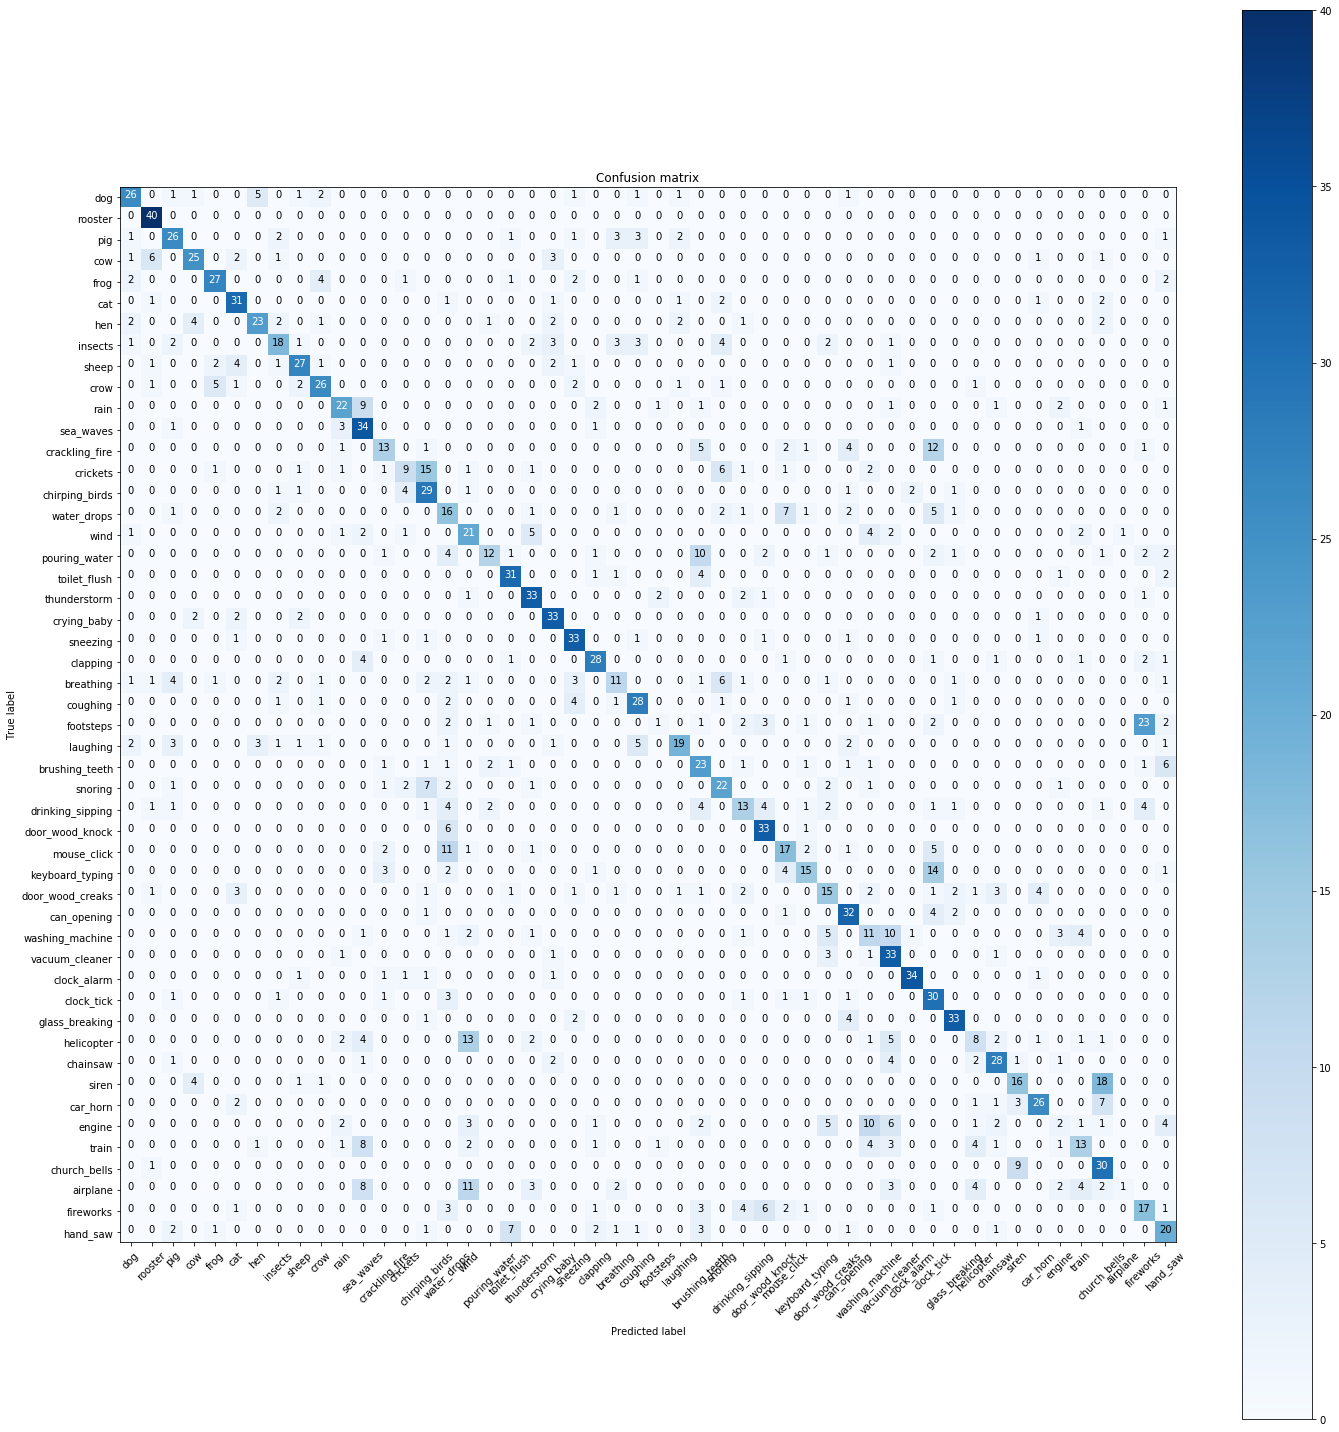

In [29]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()